In [1]:
import numpy as np
from myplotstyle import plt, get_figsize, legend_ordered

from easyquery import Query, QueryMaker
import SAGA
from SAGA import ObjectCuts as C
from SAGA import HostCuts as H

from SAGA.database import GoogleSheets
from matplotlib.colors import to_rgb

In [2]:
print(SAGA.__version__)
saga = SAGA.QuickStart()

3.0.0
SAGA `shared_dir` set to /home/yymao/Dropbox/Work/SAGA
SAGA `local_dir`  set to /home/yymao/Documents/Work/Data/SAGA


In [3]:
base = H.paper3.filter(saga.object_catalog.load_combined_base_catalog())
nhosts = len(np.unique(base["HOSTID"]))
assert nhosts == 101

In [4]:
base["radius_phys"] = np.deg2rad(base["radius"] / 3600) * base["HOST_DIST"] * 1000

In [5]:
sats = C.is_sat.filter(base)
sats_q, sats_sf = Query("quenched == 1").split(sats)

In [6]:
sats_possible = Query(~C.is_sat, C.sat_rcut, C.sample_gold | C.sample_silver, C.valid_sb).filter(base)
sats_missing = sats_possible[sats_possible["p_sat_corrected"] >= np.random.RandomState(49).rand(len(sats_possible))]

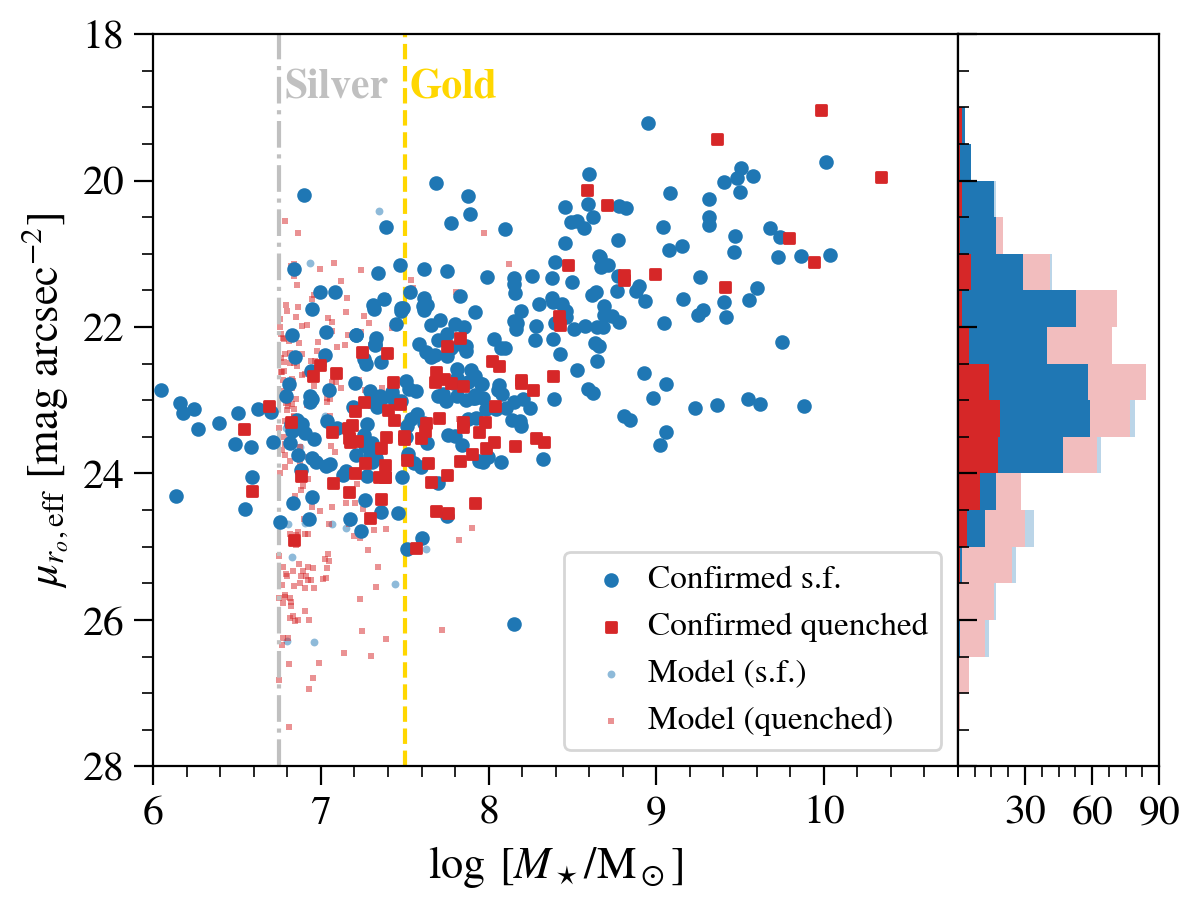

In [7]:
fig, ax = plt.subplots(1, 2, width_ratios=(4, 1))
fig.set_constrained_layout_pads(hspace=0, wspace=0, h_pad=0, w_pad=0)

kwargs_sf = dict(c="C0", label="Confirmed s.f.", s=18, zorder=10)
kwargs_q = dict(marker="s", c="C3", label="Confirmed quenched", s=15, zorder=12)
kwargs_uc_sf = dict(c='C0', marker='o', s=8, lw=0, alpha=0.5, label="Model (s.f.)")
kwargs_uc_q = dict(c='C3', marker='s', s=6, lw=0, alpha=0.5, label="Model (quenched)")

ax_this = ax[0]
ax_this.scatter(sats_sf["log_sm"], sats_sf["sb_r"], **kwargs_sf)
ax_this.scatter(sats_q["log_sm"], sats_q["sb_r"], **kwargs_q)

sats_missing_q, sats_missing_sf = Query("quenched_phony == 1").split(sats_missing)
ax_this.scatter(sats_missing_sf["log_sm_phony"], sats_missing_sf["sb_r"], **kwargs_uc_sf)
ax_this.scatter(sats_missing_q["log_sm_phony"], sats_missing_q["sb_r"], **kwargs_uc_q)


ax_this.set_ylim(28, 18)
ax_this.axvline(7.5, color="gold", ls="--")
ax_this.axvline(6.75, color="silver", ls="-.")
ax_this.set_xlim(6, 10.8)
ax_this.set_xlabel(r"$\log\;[M_\star/{\rm M}_\odot]$")
ax_this.set_ylabel("$\\mu_{r_o, \\mathrm{eff}}$ [mag arcsec$^{-2}$]")
ax_this.text(7.53, 19, "Gold", color="gold", fontweight="bold", va="bottom")
ax_this.text(6.78, 19, "Silver", color="silver", fontweight="bold", va="bottom")
ax_this.legend(loc="lower right", frameon=True, handletextpad=0.1, fontsize=12)

q_gold_silver = Query("log_sm_phony >= 6.75")
sats_sb_4 = [q_gold_silver.filter(s, "sb_r") for s in [sats_q, sats_sf, sats_missing_q, sats_missing_sf]]
colors = ["C3", "C0", to_rgb("C3") + (0.3,), to_rgb("C0") + (0.3,)]
ax[1].set_ylim(28, 18)
ax[1].hist(sats_sb_4, bins=np.linspace(18, 28, 21), histtype="barstacked", color=colors, orientation='horizontal')
ax[1].set_yticks(ax_this.get_yticks())
ax[1].set_yticklabels([])
ax[1].set_xticks([30, 60, 90])
ax[1].tick_params(axis="y", which="both", direction="in")

plt.savefig("plots/sb-mag.pdf")